In [1]:
# Adapting tutorial http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

### Load data

In [4]:
# Setting 'parse_dates' in this case parses both dates and times
# These files are too large to commit so they're uploaded locally under `/exploring_models` but not pushed
train_data = pd.read_csv('weather1_education_train.csv', parse_dates = ['timestamp'])
val_data = pd.read_csv('weather1_education_test.csv', parse_dates = ['timestamp'])

In [6]:
# Confirm df's have same number of columns
train_data.columns.difference(val_data.columns)
val_data.columns.difference(train_data.columns)

Index([], dtype='object')

In [7]:
# Format type of variable types, though in this case because these columns will be dropped
train_data['building_name'] = train_data['building_name'].astype('category')
train_data['primary_space_usage'] = train_data['primary_space_usage'].astype('category')
val_data['building_name'] = val_data['building_name'].astype('category')
val_data['primary_space_usage'] = val_data['primary_space_usage'].astype('category')

In [8]:
# train_data.columns  # lists all col names
# train_data.describe()  # summarize col value ranges
train_data.dtypes.head(10)  # see dtypes

Unnamed: 0                      int64
area                          float64
building_name                category
electricity                   float64
primary_space_usage          category
timestamp              datetime64[ns]
TemperatureC                  float64
month                           int64
year                            int64
date                            int64
dtype: object

- Dataframe is already in 'melted' / longer format

Text(0, 0.5, 'frequency')

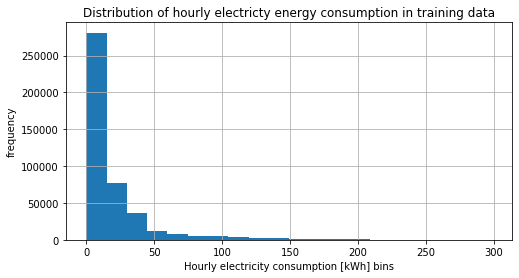

In [9]:
train_data['electricity'].hist(bins = 20, figsize = (8, 4));

plt.title('Distribution of hourly electricty energy consumption in training data')
plt.xlabel('Hourly electricity consumption [kWh] bins')
plt.ylabel('frequency')

### Create a naive baseline

#### Naive baseline 1

In [10]:
# Average energy consumption per hour by building type and weather location (this subset of data all has same weather location)

hourly_avg_by_space_usage = train_data.groupby(['primary_space_usage','hour']).mean()['electricity'].round(1).unstack()

hourly_avg_by_space_usage

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
primary_space_usage,,,,,,,,,,,,,,,,,,,,,
PrimClass,10.9,10.9,10.9,10.9,11.4,12.3,15.2,20.1,26.0,30.4,...,28.0,25.8,22.7,19.3,16.0,13.5,12.4,11.6,10.9,10.9
UnivClass,29.4,29.3,29.3,29.1,31.0,38.7,43.4,52.2,58.2,62.8,...,58.1,54.3,45.4,41.7,38.6,34.7,33.3,33.1,30.8,29.8


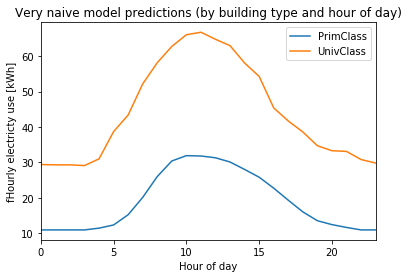

In [15]:
hourly_avg_by_space_usage.transpose().plot();
plt.title('Very naive model predictions (by building type and hour of day)')
plt.xlabel('Hour of day')
plt.ylabel('Hourly electricty use [kWh]')
plt.legend(loc = 'best')

#### Naive baseline 2

In [16]:
hourly_avg_by_space_month = train_data.groupby(['primary_space_usage', 'month', 'hour']).mean()['electricity'].round(1).unstack()
hourly_avg_by_space_month

hour                         0     1     2     3     4     5     6     7   \
primary_space_usage month                                                   
PrimClass           1      12.8  13.0  12.9  13.0  13.2  13.7  15.8  20.7   
                    2      13.2  13.2  13.2  13.2  13.6  14.0  15.9  20.5   
                    3      12.3  12.2  12.3  12.5  12.6  13.0  14.9  19.8   
                    4      10.6  10.6  10.6  10.7  11.6  13.1  16.5  21.8   
                    5       9.1   9.2   9.2   9.2   9.5  10.2  13.1  17.4   
                    6      10.2  10.1  10.1  10.2  11.2  12.8  17.5  24.6   
                    7       9.8   9.7   9.7   9.7  10.2  11.2  14.1  18.6   
                    8       9.1   9.1   9.0   8.9   9.1   9.2   9.8  10.8   
                    9      10.2  10.2  10.1  10.2  11.5  13.5  18.8  26.2   
                    10     10.2  10.2  10.2  10.3  11.3  13.3  18.4  24.8   
                    11     11.3  11.2  11.3  11.4  11.1  11.2  13.1  18.0   
                    12     12.0  12.1  12.0  12.1  12.2  12.8  14.3  18.2   
UnivClass           1      29.8  30.0  29.7  29.6  30.8  33.7  36.9  52.3   
                    2      31.5  31.4  31.2  31.0  33.6  35.3  38.3  53.2   
                    3      30.5  30.2  30.4  30.3  33.1  36.3  38.8  53.8   
                    4      29.2  29.2  29.1  28.8  31.0  41.2  46.4  50.5   
                    5      28.6  29.0  29.0  28.9  30.4  36.0  42.5  46.5   
                    6      32.7  32.6  32.5  32.0  34.8  50.2  58.6  65.8   
                    7      30.6  30.5  30.3  29.9  31.9  41.0  46.3  49.8   
                    8      24.4  24.3  24.3  23.8  25.3  31.0  33.6  34.0   
                    9      28.8  28.7  28.7  28.1  31.4  47.5  54.8  63.3   
                    10     30.2  30.3  30.7  31.0  33.7  48.4  55.0  59.8   
                    11     29.7  28.9  29.4  29.9  31.2  33.5  37.0  55.8   
                    12     26.4  26.2  26.3  26.0  25.6  29.9  32.9  42.9   

hour                         8     9   ...    14    15    16    17    18  \
primary_space_usage month              ...                                 
PrimClass           1      27.9  37.1  ...  39.4  37.3  33.6  29.9  24.8   
                    2      26.6  34.7  ...  35.5  33.3  30.1  26.5  22.2   
                    3      26.9  35.6  ...  36.9  34.1  30.4  26.2  21.1   
                    4      27.4  28.6  ...  22.7  20.5  17.5  14.2  11.9   
                    5      22.6  24.2  ...  20.2  18.5  15.9  13.0  10.5   
                    6      32.2  34.4  ...  27.6  24.4  20.3  15.3  12.0   
                    7      23.6  25.2  ...  20.5  18.4  15.7  12.7  10.7   
                    8      11.8  12.3  ...  10.8  10.3   9.8   9.3   9.1   
                    9      33.8  35.7  ...  28.9  25.8  21.5  15.9  12.6   
                    10     31.2  32.8  ...  26.5  23.5  20.1  16.3  13.8   
                    11     25.0  34.2  ...  36.8  34.5  31.3  27.8  22.7   
                    12     23.4  30.4  ...  31.5  29.7  27.3  25.0  21.0   
UnivClass           1      59.6  69.3  ...  76.7  73.9  60.3  55.4  46.9   
                    2      60.5  67.2  ...  72.7  66.3  56.5  52.2  47.4   
                    3      58.2  63.2  ...  68.5  62.7  53.6  49.9  43.9   
                    4      56.7  59.2  ...  46.4  43.4  37.2  33.9  33.2   
                    5      50.7  54.0  ...  45.9  42.5  37.5  35.8  34.3   
                    6      75.2  79.3  ...  60.8  56.0  43.0  38.4  37.8   
                    7      55.2  56.8  ...  47.5  45.6  37.5  35.5  35.1   
                    8      33.8  33.6  ...  29.8  29.0  27.2  28.8  28.0   
                    9      73.7  77.7  ...  58.2  53.8  42.3  35.3  34.3   
                    10     68.8  73.9  ...  54.8  50.1  42.5  36.5  37.1   
                    11     59.1  66.2  ...  79.4  74.7  61.6  56.1  46.1   
                    12     48.6  54.1  ...  58.1  54.7  46.5  43.6  39.9   

hour                

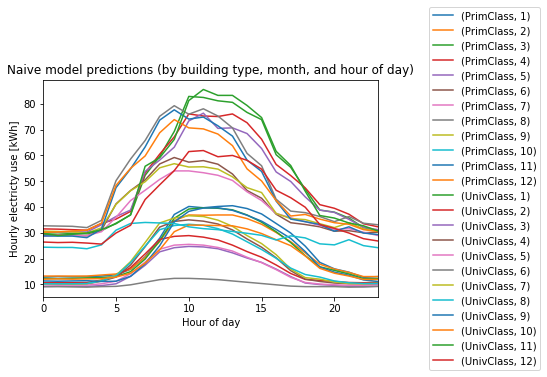

In [19]:
hourly_avg_by_space_month.transpose().plot();
plt.title('Naive model predictions (by building type, month, and hour of day)')
plt.xlabel('Hour of day')
plt.ylabel('Hourly electricty use [kWh]')
plt.legend(loc= 'center right', bbox_to_anchor=(1.5, 0.5));

- For this relatively small group of buildings in the same region, adding month appears to help account for low usage in certain months

### Fit models

In [20]:
# Functions to use for prediction evaluation

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Others in sklearn
# mean_squared_error(ytrue, ypred)
# mean_absolute_error(ytrue, ypred)

In [27]:
# Adapted from https://mlbook.explained.ai/bulldozer-testing.html#sec:tuning
# Note MAE equation below does not have np.exp() since features not previously logged
def test_valid(X, y, X_valid, y_valid, n_estimators=100,
               max_features='auto', min_samples_leaf=1):
    X_valid = X_valid.reindex(columns=X.columns)
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=max_features, 
                               min_samples_leaf=min_samples_leaf,
                               verbose = 1)
    rf.fit(X, y)
    #n = rfnnodes(rf)
    #h = np.median(rfmaxdepths(rf))
    y_pred = rf.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, y_pred)
    rmsle_valid = np.sqrt( mean_squared_error(y_valid, y_pred) )
    r2_score_valid = rf.score(X_valid, y_valid)
    #print(f"OOB R^2 {rf.oob_score_:.5f} using {n:,d} tree nodes {h} median tree height")
    print(f"Validation R^2 {r2_score_valid:.5f}, RMSLE {rmsle_valid:.5f}, MAE {mae_valid:.0f}")
    return rf, r2_score_valid, rmsle_valid, mae_valid

#### Model 1 -  area + one-hot encoded hour, day of month, day of week, month of year  +  temperature, w/o building type

In [37]:
# Using basic train/val split (50 buildings over 1 year in training set, 19 in test set), not walk-forward cross-val

# Keep only one-hot encoded categorical vairables ('primary_space_usage' is already one-hot encoded)
# Also drop the index artefact `Unnamed: 0`
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


# Use same naming conventions as https://mlbook.explained.ai/bulldozer-testing.html
X, X_valid = train_data.drop(['electricity', 'building_name', 'primary_space_usage', 'hour', 'year', 'month','weekday', 'date', 'timestamp', 'PSU_UnivClass', 'PSU_PrimClass', 'Unnamed: 0'], axis=1), val_data.drop(['electricity', 'building_name', 'primary_space_usage', 'year', 'hour','month','weekday', 'date','timestamp', 'PSU_PrimClass', 'PSU_UnivClass','Unnamed: 0'], axis=1)
y, y_valid = train_data['electricity'].values, val_data['electricity'].values



In [39]:
X_valid.head()

,area,TemperatureC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,hour_21,hour_22,hour_23,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,6149.0,7.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,6149.0,5.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6149.0,5.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,6149.0,6.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,6149.0,7.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [40]:
rf_m1, r2_score_m1, rmsle_m1, mae_m1 = \
    test_valid(X, y, X_valid, y_valid)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


Validation R^2 0.84075, RMSLE 12.37708, MAE 7


In [41]:
# Beware default random forest importances: https://explained.ai/rf-importance/index.html
# Though in this case the default approach below also yielded the same relative variable order
from rfpimp import *
I_m1 = importances(rf_m1, pd.DataFrame(X), pd.DataFrame(y))
I
# sklearn default method
# feature_importances = pd.DataFrame(mdl.feature_importances_,
#                            index = xtr.columns,
#                            columns=['importance']).sort_values('importance',ascending=False)

# feature_importances.head(10)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Usi

,Importance
Feature,
area,1.513926
wkday_6,0.171368
wkday_5,0.160016
hour_11,0.134293
TemperatureC,0.132786
hour_12,0.122161
hour_9,0.113947
hour_10,0.101884
hour_13,0.080808


- Area, and weekend days have the largest effect.
- Temperature (5th most important factor) is similar to effect of two midday (for these primary school classrooms, often ~ peak) hours
- Note - consider removing day of month as one-hot encoded, since day of week and month of year probably capture most of this variation (can test this)
- Note - when I previously accidentally included hour of day (as a numeric value) in addition to as one-hot encoded, it had the highest feature importance, and the overall MAE was smaller

#### Model 2 - area + one-hot encoded hour, day of month, day of week, month of year , w/o temperature


In [46]:
# Using same train/test split

X2, X2_valid = train_data.drop(['TemperatureC','electricity', 'building_name', 'primary_space_usage', 'hour', 'year', 'month','weekday', 'date', 'timestamp', 'PSU_UnivClass', 'PSU_PrimClass', 'Unnamed: 0'], axis=1), val_data.drop(['TemperatureC','electricity', 'building_name', 'primary_space_usage', 'year', 'hour','month','weekday', 'date','timestamp', 'PSU_PrimClass', 'PSU_UnivClass','Unnamed: 0'], axis=1)
y2, y2_valid = train_data['electricity'].values, val_data['electricity'].values

rf_m2, r2_score_m2, rmsle_m2, mae_m2 = \
    test_valid(X2, y2, X2_valid, y2_valid)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


Validation R^2 0.83741, RMSLE 12.50646, MAE 7


In [47]:
I_m2 = importances(rf_m2, pd.DataFrame(X2), pd.DataFrame(y2))
I_m2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

,Importance
Feature,
area,1.537258
wkday_5,0.163304
wkday_6,0.161931
hour_12,0.130278
hour_11,0.106172
hour_10,0.100096
hour_13,0.089996
hour_9,0.088585
month_8,0.077107


- After removing hourly temperature data - very slight decrease in the validation R^2, and slight increase in the RMSLE, MAE unchanged ( to 1 sf)
- Relative importance of top 5 features otherwise same

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


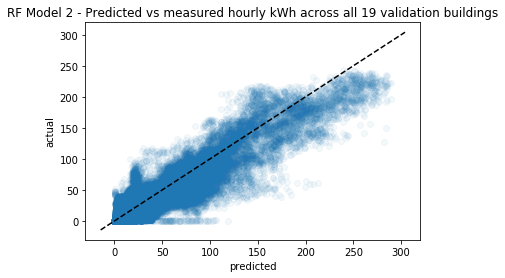

In [50]:
fig, ax = plt.subplots()
plt.scatter(rf_m2.predict(X2_valid), y2_valid, alpha=0.05)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("RF Model 2 - Predicted vs measured hourly kWh across all 19 validation buildings");
ax.plot(ax.get_xlim(), ax.get_xlim(), color = 'black', linestyle='dashed');

#### Model 3 - area, + one-hot encoded hour, day of month, day of week, month of year  + building type 

- No hourly temperature
- Note this smaller dataset only has two building types, of of which has 58 buildings (PrimClass) and one only has one (UnivClass)

In [51]:
# Using same train/test split
# Now including 'PSU_PrimClass' and 'PSU_UnivClass' as one-hot encoded

X3, X3_valid = train_data.drop(['TemperatureC','electricity', 'building_name', 'primary_space_usage', 'hour', 'year', 'month','weekday', 'date', 'timestamp', 'Unnamed: 0'], axis=1), val_data.drop(['TemperatureC','electricity', 'building_name', 'primary_space_usage', 'year', 'hour','month','weekday', 'date','timestamp', 'Unnamed: 0'], axis=1)
y3, y3_valid = train_data['electricity'].values, val_data['electricity'].values

rf_m3, r2_score_m3, rmsle_m3, mae_m3 = \
    test_valid(X3, y3, X3_valid, y3_valid)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Validation R^2 0.83723, RMSLE 12.51319, MAE 7


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [52]:
I_m3 = importances(rf_m3, pd.DataFrame(X3), pd.DataFrame(y3))
I_m3

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Usi

,Importance
Feature,
area,1.643658
wkday_6,0.191865
wkday_5,0.174251
hour_12,0.118163
month_8,0.095894
hour_11,0.091366
hour_10,0.088459
hour_15,0.087932
hour_9,0.084638


- In this small dataset, buildingtype is not even in the top 15 features by variable importance, but this may change on a more diverse dataset
- MAE, and R^2 similar to M1 and M2 above

### Tune hyperparameters

- Assume we will proceed with the third model (no hourly temperature, but yes to building type)

In [53]:
# https://mlbook.explained.ai/bulldozer-testing.html#sec:9.3.1 

def test_valid(X, y, X_valid, y_valid, n_estimators=100,
               max_features='auto', min_samples_leaf=1):
    X_valid = X_valid.reindex(columns=X_valid.columns)
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=max_features, 
                               min_samples_leaf=min_samples_leaf,
                               verbose = 1)
    rf.fit(X, y)
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    y_pred = rf.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, y_pred)
    rmsle_valid = np.sqrt( mean_squared_error(y_valid, y_pred) )
    r2_score_valid = rf.score(X_valid, y_valid)
    print(f"OOB R^2 {rf.oob_score_:.5f} using {n:,d} tree nodes {h} median tree height")
    print(f"Validation R^2 {r2_score_valid:.5f}, RMSLE {rmsle_valid:.5f}, MAE ${mae_valid:.0f}")
    return rf, r2_score_valid, rmsle_valid, mae_valid

In [54]:

# First, max_features
ntrees = 50
minleaf = 1
for maxf in np.arange(.1,.6,.1):
    print(f"n_estimators={ntrees}, max_features={maxf:.1f}, min_samples_leaf={minleaf}")
    test_valid(xtr, ytr, xts, yts,
               max_features=maxf, min_samples_leaf=minleaf)

n_estimators=50, max_features=0.1, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


OOB R^2 0.89282 using 54,795,630 tree nodes 58.0 median tree height
Validation R^2 0.88052, RMSLE 10.72112, MAE $6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


n_estimators=50, max_features=0.2, min_samples_leaf=1
OOB R^2 0.93848 using 54,450,256 tree nodes 54.0 median tree height
Validation R^2 0.86298, RMSLE 11.48105, MAE $7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


n_estimators=50, max_features=0.3, min_samples_leaf=1
OOB R^2 0.96376 using 53,587,996 tree nodes 52.0 median tree height
Validation R^2 0.85406, RMSLE 11.84894, MAE $7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


n_estimators=50, max_features=0.4, min_samples_leaf=1
OOB R^2 0.97722 using 52,561,258 tree nodes 52.0 median tree height
Validation R^2 0.84997, RMSLE 12.01381, MAE $7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


n_estimators=50, max_features=0.5, min_samples_leaf=1
OOB R^2 0.98222 using 51,445,754 tree nodes 52.0 median tree height
Validation R^2 0.84739, RMSLE 12.11629, MAE $7


- For this small subset of data,  best validation r^2 and RMSLE is with max_features = 0.1
- max_features is "the number of features to consider when looking at the best split", ie with 44 features, 4 would be considered per split

In [55]:
# Next minleaf 

maxf = .1
for minleaf in range(2,7):
   print(f"n_estimators={ntrees}, max_features={maxf}, min_samples_leaf={minleaf}")
   test_valid(xtr, ytr, xts, yts,
              max_features=maxf, min_samples_leaf=minleaf)

n_estimators=50, max_features=0.1, min_samples_leaf=2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


OOB R^2 0.90312 using 23,154,170 tree nodes 56.0 median tree height
Validation R^2 0.90355, RMSLE 9.63242, MAE $6
n_estimators=50, max_features=0.1, min_samples_leaf=3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


OOB R^2 0.90846 using 14,490,512 tree nodes 54.0 median tree height
Validation R^2 0.90469, RMSLE 9.57540, MAE $6
n_estimators=50, max_features=0.1, min_samples_leaf=4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


OOB R^2 0.90939 using 10,302,646 tree nodes 54.0 median tree height
Validation R^2 0.89957, RMSLE 9.82928, MAE $6
n_estimators=50, max_features=0.1, min_samples_leaf=5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


OOB R^2 0.90576 using 7,965,100 tree nodes 53.0 median tree height
Validation R^2 0.89813, RMSLE 9.89926, MAE $6
n_estimators=50, max_features=0.1, min_samples_leaf=6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


OOB R^2 0.90195 using 6,454,746 tree nodes 52.0 median tree height
Validation R^2 0.89504, RMSLE 10.04831, MAE $6


- In this case, highest validation R^2 and lowest RMSLE with min_samples_leaf = 3, though again this may change on a larger and more hetrogenous dataset

### Fit model with selected hyperparameters


In [57]:
rf_m3_tuned, r2_score_m3, rmsle_m3, mae_m3 = \
    test_valid(X3, y3, X3_valid, y3_valid,
              max_features=.1,
              min_samples_leaf=3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s


OOB R^2 0.90506 using 13,220,752 tree nodes 69.0 median tree height
Validation R^2 0.88180, RMSLE 10.66318, MAE $6


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


#### Output predictions


In [72]:
y_pred = rf_m3_tuned.predict(X3_valid)
    

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


#### Compare to Naive model
- In progress

In [73]:
# TODO
https://github.com/dmgt/gdso_2019/blob/naive_model/notebooks/naive_model.ipynb

def naive_model(df, profile, num_buildings):
    '''
    profile is a list of features used to calculate hourly avg
    #profile = ['primary_space_usage']
    '''
    one_year = 8757
    profile.append('hour')
    hourly_avg = df.groupby(profile).mean()['electricity'].round(1).unstack()
    df_2 = pd.DataFrame(columns=['PrimClass', 'UnivClass'])
    hourly_avg = hourly_avg.transpose()
    for _ in range(365):
        df_2 = pd.concat([df_2, hourly_avg], axis=0, ignore_index=True)
    df_2 = df_2.iloc[:one_year]
    y_true = np.array(df['electricity']).reshape((num_buildings, one_year))
    buildings = df['building_name'].unique()
    y_pred = np.array([])
    profile.remove('hour')
    for building in buildings:
        building_profile = df[df['building_name']==building][profile].iloc[0]
        y = df_2[building_profile]
        y = np.array(y)
        y_pred = np.append(y_pred, y)
    return y_true, y_pred.reshape((num_buildings, one_year))


In [78]:
y, y_naive = naive_model(train_data, ['primary_space_usage'], 50)

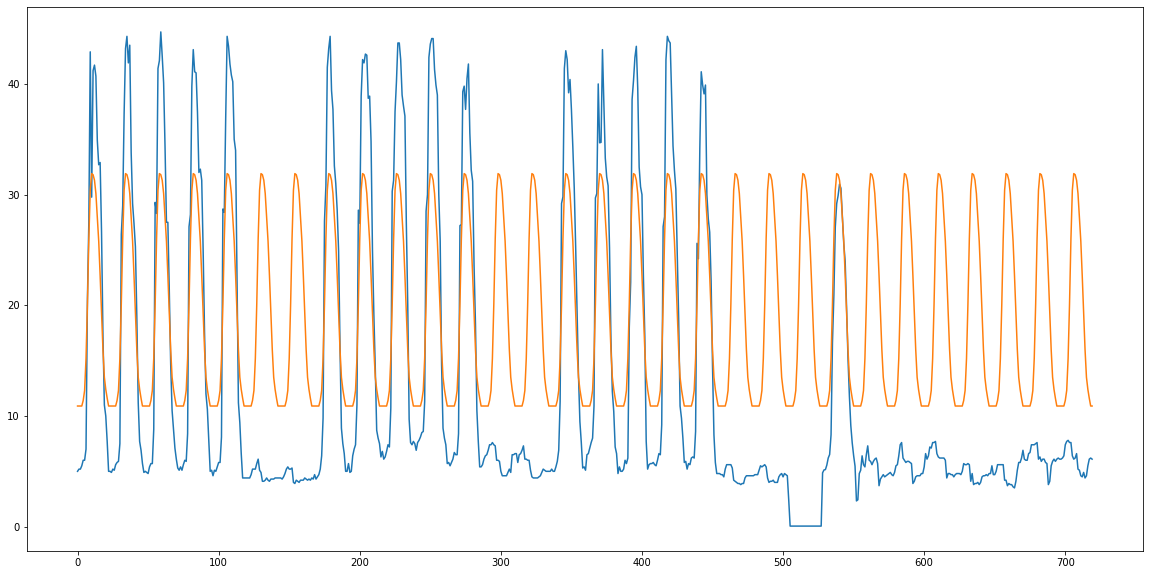

In [81]:
plt.figure(figsize=(20, 10))
plt.plot(y[0][:24*30])
plt.plot(y_pred[0][:24*30]);

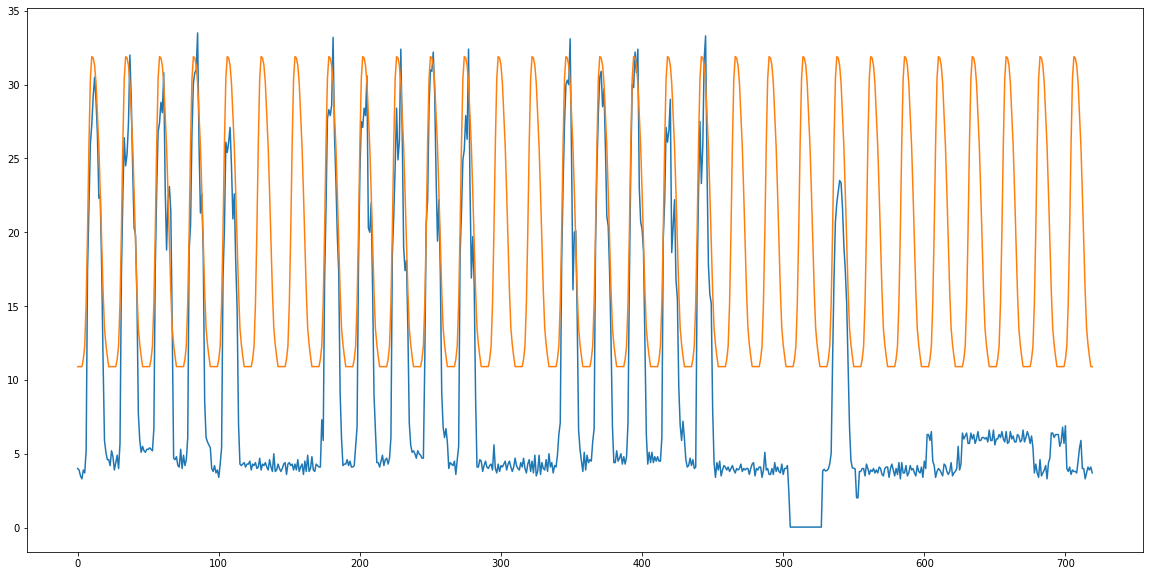

In [77]:
plt.figure(figsize=(20, 10))
plt.plot(y[1][:24*30])
plt.plot(y_pred[1][:24*30]);